In [16]:
#!git clone https://github.com/NVlabs/stylegan
#!git clone https://github.com/iyaja/stylegan-encoder.git
!git clone https://github.com/wlgh312/BSM_stylegan.git
#!git clone https://github.com/pbaylies/stylegan-encoder

Cloning into 'BSM_stylegan'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 59 (delta 6), reused 56 (delta 6), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [17]:
!mkdir /content/BSM_stylegan/raw_images

mkdir: cannot create directory ‘/content/BSM_stylegan/raw_images’: File exists


In [18]:
%cd /content/BSM_stylegan

/content/BSM_stylegan


In [19]:
!pip install tqdm
!pip install typeguard
!pip install psutil
!pip install humanize
from IPython.display import Image
from google.colab import files
import os
import sys
import pickle
import numpy as np
import PIL.Image
from PIL import Image
import config
from tqdm import tqdm

In [0]:
sys.path.append('/content/stylegan/dnnlib')
import dnnlib
import dnnlib.tflib as tflib#pre-trained networks
dnnlib.tflib.init_tf()

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
entity_to_url={
        'faces':'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'
}
model_cache={}

In [0]:
def fetch_model(name):
  if model_cache.get(name):
    return model_cache[name]

  url = entity_to_url[name]
  with dnnlib.util.open_url(url, cache_dir='cache') as f:
    _G, _D, Gs = pickle.load(f)
    model_cache[name] = Gs
  return model_cache[name]

In [0]:
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=20)

In [0]:
seed=10000000
interpolate_dim=1#max:511
#mapping size
width=1#max:100
height=1
#image size
image_dim=100
interpolate=np.linspace(0, 30, width)
name='faces'
Gs=fetch_model(name)

In [0]:
def apply_latent_fudge(fudge, target_latent):
  copy=np.copy(target_latent)
  copy[interpolate_dim]+=fudge
  return copy

In [0]:
def v_linspace(i):
  v = np.array(list(map(lambda l: np.linspace(dst_dlatents[i][l], height), range(dst_dlatents.shape[1]))))
  v = v.transpose()
  return v

In [0]:
#dst:target image
def style_mixing(png, Gs, w, h, src_dlatents, dst_dlatents, style_ranges):
  print(png)
  src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
  dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

  canvas = PIL.Image.new('RGB', (w * (len(src_dlatents) + 1), h*(len(dst_dlatents) + 1)), 'white')
  for col, src_image in enumerate(list(src_images)):
    canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
  for row, dst_image in enumerate(list(dst_images)):
    canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
    row_dlatents = np.stack([dst_dlatents[row]] * len(src_dlatents))
    row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
    row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
    for col, image in enumerate(list(row_images)):
      canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
  canvas.save(png)
  return canvas.resize((512, 512))

In [0]:
test_file=np.load('/content/gdrive/My Drive/data/npy_result/hathaway_01.npy')

0


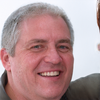




Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:238: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 183.2355; lr 0.0300:   0% 0/100 [00:07<?, ?it/s]
seed_1: loss 183.2355; lr 0.0300:   1% 1/100 [00:07<12:53,  7.81s/it]
seed_1: loss 139.6128; lr 0.0300:   1% 1/100 [00:08<12:53,  7.81s/it]
seed_1: loss 139.6128; lr 0.0300:   2% 2/100 [00:08<09:09,  5.60s/it]
seed_1: loss 127.9083; lr 0.0300:   2% 2/100 [00:08<09:09,  5.60s/it]
seed_1: loss 127.9083; lr 0.0300:   3% 3/100 [00:08<06:33,  4.06s/it]
seed_1: loss 122.0545; lr 0.0300:   3% 3/100 [00:09<06:33,  4.06s/it]
seed_1: loss 122.0545; lr 0.0300: 

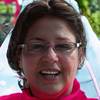




Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:238: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 192.1509; lr 0.0300:   0% 0/100 [00:07<?, ?it/s]
seed_1: loss 192.1509; lr 0.0300:   1% 1/100 [00:07<12:35,  7.63s/it]
seed_1: loss 148.5245; lr 0.0300:   1% 1/100 [00:07<12:35,  7.63s/it]
seed_1: loss 148.5245; lr 0.0300:   2% 2/100 [00:08<08:56,  5.47s/it]
seed_1: loss 136.9402; lr 0.0300:   2% 2/100 [00:08<08:56,  5.47s/it]
seed_1: loss 136.9402; lr 0.0300:   3% 3/100 [00:08<06:24,  3.97s/it]
seed_1: loss 132.3294; lr 0.0300:   3% 3/100 [00:08<06:24,  3.97s/it]
seed_1: loss 132.3294; lr 0.0300: 

'mix_result.png'

In [33]:
for i in range(seed):
  #src_image=generate_image(seed)
  print(i)
  rnd=np.random.RandomState(i)
  init_latent1=rnd.randn(1, Gs.input_shape[1])[0]
  applier1 = lambda f: apply_latent_fudge(f, init_latent1)
  latent1=np.array(list(map(applier1, interpolate)))
  image = Gs.run(latent1, None, **synthesis_kwargs)
  img = PIL.Image.fromarray(image[0], 'RGB')
  img = img.resize((image_dim, image_dim), PIL.Image.ANTIALIAS)
  display(img)
  img.save('/content/BSM_stylegan/raw_images/seed.jpg')
  
  #src_image to npy
  !python npy_encoder.py seed.jpg --output_video=True=0.002 --iterations=500 --use_l1_penalty=0.2 raw_images/ aligned_images/ generated_images/ latent_representation/
  dst_file=np.load('/content/BSM_stylegan/latent_representation/seed_1.npy')
  style_mixing(os.path.join('/content/gdrive/My Drive/data/style_result', 'mix_result.png'), Gs, w=1024, h=1024, src_dlatents=dst_file.reshape((1, 18, 512)), dst_dlatents=test_file.reshape((1, 18, 512)), style_ranges=[range(6, 14)])
  if i == 1:#dst_image == style_mixing(age, gender)
    break
display('mix_result.png')